In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline

data = pd.read_csv("data.csv", header = None)

X = data.loc[:, 0:5]
y = data.loc[:, 6]

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

##  Random grid search

Pomocu random grid searcha mogu se zadati opsezi vrednosti hiperparametara od kojih ce on na slucajan nacin birati kombinacije i racunati K-fold kros validaciju za svaku kombinaciju. Na kraju ce biti sacuvan najbolji model i njegovi parametri. Velika prednost random grid search-a je to sto se na brz nacin mogu pronaci solidni parametri jer ne razmatra sve moguce kombinacije vec samo one koje je slucajno odabrao.

Nakon primene random grid search-a moze se primeniti grid search sa vrednostima parametara blizu onih koje je pronasao random grid search. Na taj nacin se ne ispituju samo slucajne komninacije hiperparametara vec sve moguce kombinacije, i moguce je naci najbolji moguci model. 

In [2]:
n_estimators = [10, 50, 100, 150, 200, 250, 300, 350, 400]
max_features = [2, 4, 6, 'auto']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': [2, 4, 6, 'auto'],
 'min_samples_leaf': [1, 2, 5],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400]}


In [3]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [4]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 10,
 'bootstrap': True}

In [5]:
base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7482517482517482

In [6]:
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)
accuracy_score(y_test, y_pred)

0.7832167832167832

In [7]:
estimators = [10, 50, 100, 150, 200, 250, 300, 350, 400]

In [8]:
def results_base(estimators, X_train, y_train, X_test, y_test):
    results = []
    for i in range(len(estimators)):
        base_model = RandomForestClassifier(n_estimators = estimators[i], random_state = 42)
        base_model.fit(X_train, y_train)
        y_pred = base_model.predict(X_test)
        results.append(accuracy_score(y_pred, y_test))
    return results

def results(model, estimators, X_train, y_train, X_test, y_test):
    results = []
    for i in range(len(estimators)):
        model.best_params_['n_estimators'] = estimators[i]
        params = model.best_params_
        model_ = RandomForestClassifier().set_params(**params)
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)
        results.append(accuracy_score(y_pred, y_test))
    return results

Na sledecoj slici mogu se videti tacnosti za Base klasifikator bez tunovanih hiperparametara i za Random klasifikator. Iako deluje da base klasifikator ima bolju tacnost, ako se poredi tacnost na trening setu, moze se uociti da base klasifikator overfitt-uje podatke.

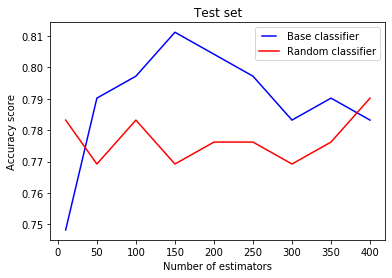

In [9]:
line1, = plt.plot(estimators, results_base(estimators, X_train, y_train, X_test, y_test), 'b', label="Base classifier")
line2, = plt.plot(estimators, results(rf_random, estimators, X_train, y_train, X_test, y_test), 'r', label="Random classifier")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Number of estimators')
plt.title('Test set')
plt.show()

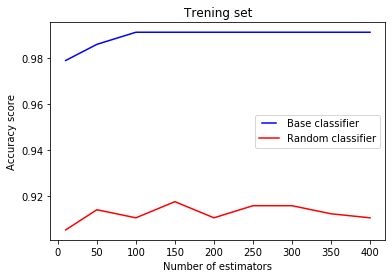

In [10]:
line1, = plt.plot(estimators, results_base(estimators, X_train, y_train, X_train, y_train), 'b', label="Base classifier")
line2, = plt.plot(estimators, results(rf_random, estimators, X_train, y_train, X_train, y_train), 'r', label="Random classifier")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Number of estimators')
plt.title('Trening set')
plt.show()

Nakon analize performansi modela pronadjenog random grid search-om, nije lose pokusati i dalje tunovanje hiperparametara pomocu standardnog grid search-a. 

In [11]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, None],
    'max_features': [2, 4, 6, 'auto'],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 150, 200, 300, 400]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [12]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.1min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [13]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)
accuracy_score(y_test, y_pred)

0.7832167832167832

In [14]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

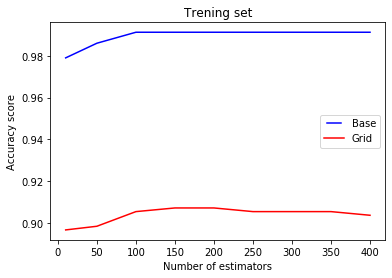

In [15]:
line1, = plt.plot(estimators, results_base(estimators, X_train, y_train, X_train, y_train), 'b', label="Base")
line2, = plt.plot(estimators, results(grid_search, estimators, X_train, y_train, X_train, y_train), 'r', label="Grid")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Number of estimators')
plt.title('Trening set')
plt.show()

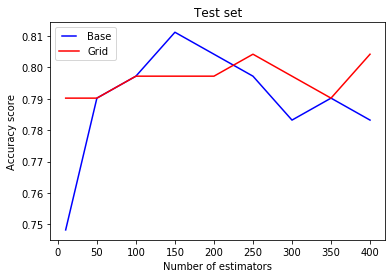

In [16]:
line1, = plt.plot(estimators, results_base(estimators, X_train, y_train, X_test, y_test), 'b', label="Base")
line2, = plt.plot(estimators, results(grid_search, estimators, X_train, y_train, X_test, y_test), 'r', label="Grid")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Number of estimators')
plt.title('Test set')
plt.show()

Moze se primetiti da je tacnost modela bolja, kao i da mu je greska na treningu "realna" u odnosu na base estimator.